<a href="https://colab.research.google.com/github/fyng/PassplayNET/blob/main/NFLDataBowl2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Kaggle Challenge

Refer to https://www.kaggle.com/general/74235

1. Create and upload kaggle.json

In [84]:
#! pip install -q kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json

# # check if connection is working
# ! kaggle datasets list

In [85]:
#! kaggle competitions download -c nfl-big-data-bowl-2023
#! unzip /content/nfl-big-data-bowl-2023.zip

How train is made?

Every row is a unique play in a unique game

Every row contains relevant data of every player. 
* each variable spans 1 second, spaced with every 1/10 of a second (only 2 NAs)
* every record is the same length

Action_time based on different events (Mason and Tad)

Pass yards (Feiyang & Eric)

# Explore Data

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from google.colab import files

### Play Data

Play data
* `gameId`: Game identifier, unique (numeric)
* `playId`: Play identifier, not unique across games (numeric)
* `playDescription`: Description of play (text)
* `quarter`: Game quarter (numeric)
* `down`: Down (numeric)
* `yardsToGo`: Distance needed for a first down (numeric)
* `possessionTeam`: Team abbr of team on offense with possession of ball (text)
* `defensiveTeam`: Team abbr of team on defense (text)
* `yardlineSide`: 3-letter team code corresponding to line-of-scrimmage (text)
* `yardlineNumber`: Yard line at line-of-scrimmage (numeric)
* `gameClock`: Time on clock of play (MM:SS)
* `preSnapHomeScore`: Home score prior to the play (numeric)
* `preSnapVisitorScore`: Visiting team score prior to the play (numeric)
* `passResult`: Dropback outcome of the play (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, R: Scramble, text)
* `penaltyYards`: yards gained by offense by penalty (numeric)
* `prePenaltyPlayResult`: Net yards gained by the offense, before penalty yardage (numeric)
* `playResult`: Net yards gained by the offense, including penalty yardage (numeric)
* `foulName[i]`: Name of the i-th penalty committed during the play. i ranges between 1 and 3 (text)
* `foulNFLId[i]`: nflId of the player who comitted the i-th penalty during the play. i ranges between 1 and 3 (numeric)
* `absoluteYardlineNumber`: Distance from end zone for possession team (numeric)
* `offenseFormation`: Formation used by possession team (text)
* `personnelO`: Personnel used by offensive team (text)
* `defendersInTheBox`: Number of defenders in close proximity to line-of-scrimmage (numeric)
* `personnelD`: Personnel used by defensive team (text)
* `dropbackType`: Dropback categorization of quarterback (text)
* `pff_playAction`: indicator for whether offense executes play action fake on the play. Variable provided by PFF (binary)
* `pff_passCoverage`: Coverage scheme of defense. Variable provided by PFF (text)
* `Bracket`: Recorded in the field and up to the 12 yard line in the red zone – when two offensive players have an in and out bracket by two defenders
* `Goal Line`: Calls where a Goal Line defense is used.
* `Red Zone`: Calls that are typically specific to the Red Zone and do not occur in the field often
* `Prevent`: Special end of half or end of game situations where a Prevent defense is utilized
* `Miscellaneous`: Coverage concepts that we feel do not comfortably fit into any of our coverage categories
* `pff_passCoverageType`: Whether defense's coverage type was man, zone or other. Variable provided by PFF (text)



### Tracking Data

Tracking data
Files week[week].csv contains player tracking data from week [week].

* `gameId`: Game identifier, unique (numeric)
* `playId`: Play identifier, not unique across games (numeric)
* `nflId`: Player identification number, unique across players. When value is NA, row corresponds to ball. (numeric)
* `frameId`: Frame identifier for each play, starting at 1 (numeric)
* `time`: Time stamp of play (time, yyyy-mm-dd, hh:mm:ss)
* `jerseyNumber`: Jersey number of player (numeric)
* `club`: Team abbrevation of corresponding player (text)
* `playDirection`: Direction that the offense is moving (left or right)
* `x`: Player position along the long axis of the field, 0 - 120 yards. See Figure 1 below. (numeric)
* `y`: Player position along the short axis of the field, 0 - 53.3 yards. See Figure 1 below. (numeric)
* `s`: Speed in yards/second (numeric)
* `a`: Acceleration in yards/second^2 (numeric)
* `dis`: Distance traveled from prior time point, in yards (numeric)
* `o`: Player orientation (deg), 0 - 360 degrees (numeric)
* `dir`: Angle of player motion (deg), 0 - 360 degrees (numeric)
* `event`: Tagged play details, including moment of ball snap, pass release, pass catch, tackle, etc (text)

In [87]:
from google.colab import drive
drive.mount('gdrive/')
path = "gdrive/My Drive" # Change path to location of data if necessary

file1 = '/'.join((path,'plays.csv'))

pl = pd.read_csv(file1)

field = pl
field.head()

data = pd.read_csv("https://raw.githubusercontent.com/fyng/PassplayNET/main/training_data.csv")
data = data.drop(['action_time', 'event'], axis = 1)

data_norm = data 


Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).


In [88]:
import numpy as np
#Normalized data for separate usage if needed, one-hots included

rowIndex = 0
for p in range(len(data_norm)):
  startNum = data_norm.columns.get_loc('x_0_C') #column that starts reference
  i = 0 #shifts between positions
  for int in range(5):
    newReference = startNum + i
    startPosition = data_norm.iloc[rowIndex, newReference]
    j = 0 #shifts across time
    for int in range(11):
      columnShift = newReference + (5*j)
      data_norm.iloc[rowIndex, columnShift] -= startPosition
      j = j + 1
    i = i + 1
  rowIndex = rowIndex + 1

rowIndex = 0
newReference = 0

startNum = columnShift + 1 #start reference at first y-value
for p in range(len(data_norm)):
  i = 0 #shifts between positions
  for int in range(5):
    newReference = startNum + i
    startPosition = data_norm.iloc[rowIndex, newReference]
    j = 0 #shifts across time
    for int in range(11):
      columnShift = newReference + (5*j)
      data_norm.iloc[rowIndex, columnShift] -= startPosition
      j = j + 1
    i = i + 1
  rowIndex = rowIndex + 1

rowTemp = 0
data_norm['T_Diff'] = 0
for pt in range(len(data_norm)):
  rowToChange = data_norm.iloc[rowTemp, :]
  complete = rowToChange.loc['T_Diff']
  temp1 = rowToChange.loc['y_1_LT']
  temp2 = rowToChange.loc['y_1_RT']
  gap = (temp1 - temp2) #abs or not (can change)
  data_norm.iloc[rowTemp, data_norm.columns.get_loc('T_Diff')] = gap
  rowTemp += 1
  
rowTemp = 0
data_norm['G_Diff'] = 0
for pt in range(len(data_norm)):
  rowToChange = data_norm.iloc[rowTemp, :]
  complete = rowToChange.loc['G_Diff']
  temp1 = rowToChange.loc['y_1_LG']
  temp2 = rowToChange.loc['y_1_RG']
  gap = (temp1 - temp2) #abs or not (can change)
  data_norm.iloc[rowTemp, data_norm.columns.get_loc('G_Diff')] = gap
  rowTemp += 1


In [89]:
# Position data of all players for the first 1 second of the game, at 0.1 second time resolution
# Position data: x-y position, speed, acceleration, distance traveled, orientation, direction

play = field[['gameId', 'playId', 'defendersInBox', 'passResult', 'yardsToGo', 'playResult', 'down', 'pff_passCoverage', 'pff_playAction']]

data_norm_plays = pd.merge(data_norm, play, on=['gameId', 'playId']) #Change data_norm to data_yesPass if only want competions


In [90]:
data_norm = data_norm_plays #look at merged file
columnNumber = data_norm.columns.get_loc('passResult')
toDrop = []
i = 0
for row in range(len(data_norm)): #This loop throws out incomplete passes
  if i < len(data_norm):
    passR = data_norm.iloc[i, columnNumber]
    if passR == "I":
      toDrop.append(i)
  i = i + 1

data_norm_plays = data_norm.drop(toDrop, axis = 0) #data_yesPass only includes completed passes

# remove NaN and Inf

data_norm_plays = data_norm_plays[~data_norm_plays.isin([np.nan, np.inf, -np.inf]).any(1)]

data_norm_plays.head()

,gameId,playId,x_0_C,x_0_LT,x_0_LG,x_0_RG,x_0_RT,x_0.1_C,x_0.1_LT,x_0.1_LG,...,dir_1_RT,T_Diff,G_Diff,defendersInBox,passResult,yardsToGo,playResult,down,pff_passCoverage,pff_playAction
1,2021090900,137,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.02,...,59.29,-0.92,-0.29,6.0,C,10,28,1,Cover-3,0
2,2021090900,187,0.0,0.0,0.0,0.0,0.0,0.07,0.03,0.06,...,71.08,-0.94,0.09,6.0,C,6,5,2,Cover-3,0
5,2021090900,410,0.0,0.0,0.0,0.0,0.0,-0.03,-0.03,-0.01,...,256.04,0.89,0.38,6.0,C,5,10,2,Cover-1,0
7,2021090900,456,0.0,0.0,0.0,0.0,0.0,-0.03,-0.09,-0.01,...,254.30,1.13,-0.18,6.0,C,10,19,2,Cover-6,0
8,2021090900,480,0.0,0.0,0.0,0.0,0.0,-0.03,-0.05,-0.01,...,263.07,0.87,0.71,6.0,C,10,28,1,Cover-3,0


In [91]:
data_norm_plays

,gameId,playId,x_0_C,x_0_LT,x_0_LG,x_0_RG,x_0_RT,x_0.1_C,x_0.1_LT,x_0.1_LG,...,dir_1_RT,T_Diff,G_Diff,defendersInBox,passResult,yardsToGo,playResult,down,pff_passCoverage,pff_playAction
1,2021090900,137,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.02,...,59.29,-0.92,-0.29,6.0,C,10,28,1,Cover-3,0
2,2021090900,187,0.0,0.0,0.0,0.0,0.0,0.07,0.03,0.06,...,71.08,-0.94,0.09,6.0,C,6,5,2,Cover-3,0
5,2021090900,410,0.0,0.0,0.0,0.0,0.0,-0.03,-0.03,-0.01,...,256.04,0.89,0.38,6.0,C,5,10,2,Cover-1,0
7,2021090900,456,0.0,0.0,0.0,0.0,0.0,-0.03,-0.09,-0.01,...,254.30,1.13,-0.18,6.0,C,10,19,2,Cover-6,0
8,2021090900,480,0.0,0.0,0.0,0.0,0.0,-0.03,-0.05,-0.01,...,263.07,0.87,0.71,6.0,C,10,28,1,Cover-3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8065,2021110100,4113,0.0,0.0,0.0,0.0,0.0,0.03,0.04,0.01,...,92.29,-0.81,-0.15,4.0,C,15,29,2,Cover-2,0
8066,2021110100,4310,0.0,0.0,0.0,0.0,0.0,0.03,0.05,0.00,...,76.46,-1.36,-0.44,4.0,S,8,-8,3,Bracket,0
8067,2021110100,4363,0.0,0.0,0.0,0.0,0.0,-0.05,-0.01,0.00,...,249.27,1.19,1.31,5.0,C,10,3,1,Cover-2,0
8068,2021110100,4392,0.0,0.0,0.0,0.0,0.0,-0.06,-0.01,0.00,...,253.31,1.00,0.90,6.0,S,7,-8,2,Cover-2,0


In [92]:
data_norm = data_norm_plays #look at merged file
rowTemp = 0
data_norm['Down1'] = 0
data_norm['Down2'] = 0
data_norm['Down3'] = 0
data_norm['Down4'] = 0
tempDown = 0
for pt in range(len(data_norm)): #manual one-hot encoding
  rowToChange = data_norm.iloc[rowTemp, :]
  tempDown = rowToChange.loc['down']
  if tempDown ==  1:
    data_norm.iloc[rowTemp, data_norm.columns.get_loc('Down1')] = 1
  elif tempDown == 2:
    data_norm.iloc[rowTemp, data_norm.columns.get_loc('Down2')] = 1
  elif tempDown == 3:
    data_norm.iloc[rowTemp, data_norm.columns.get_loc('Down3')] = 1
  elif tempDown == 4:
    data_norm.iloc[rowTemp, data_norm.columns.get_loc('Down4')] = 1
    #Edge Case, Down = 0
  rowTemp += 1

counter = 0
data_norm['Cover-1'] = 0
data_norm['Cover-2'] = 0
data_norm['Cover-3'] = 0
data_norm['Cover-6'] = 0
data_norm['Quarters'] = 0
data_norm['Cover-0'] = 0
data_norm['2-Man'] = 0
for row in range(len(data_norm)):
  zz = data_norm['pff_passCoverage']
  x = zz.iloc[counter]
  if x == 'Cover-1':
    data_norm.iloc[counter, data_norm.columns.get_loc('Cover-1')] = 1
  elif x == 'Cover-2':
    data_norm.iloc[counter, data_norm.columns.get_loc('Cover-2')] = 1
  elif x == 'Cover-3':
    data_norm.iloc[counter, data_norm.columns.get_loc('Cover-3')] = 1
  elif x == 'Cover-6':
    data_norm.iloc[counter, data_norm.columns.get_loc('Cover-6')] = 1
  elif x == 'Cover-0':
    data_norm.iloc[counter, data_norm.columns.get_loc('Cover-0')] = 1
  elif x == '2-Man':
    data_norm.iloc[counter, data_norm.columns.get_loc('2-Man')] = 1
  #EXCLUDING RED ZONE
  counter += 1

### Understanding the Data

# Models

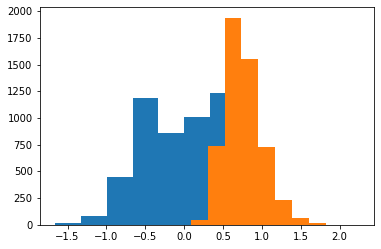

In [94]:
data = data_norm
X = data.loc[:, 'x_0_C':'y_1_RT']
names = X.columns
scalar = preprocessing.StandardScaler()
X = scalar.fit_transform(X)

plt.hist(X.mean(axis = 1))
plt.hist(X.std(axis = 1))

y = data['playResult']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
# try simple linear regression first

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [105]:
import sklearn.metrics as skm
y2 = reg.predict(X)
skm.r2_score(y, y2)

0.01807890749876162

In [97]:
LinearRegression().fit(X, y)

LinearRegression()

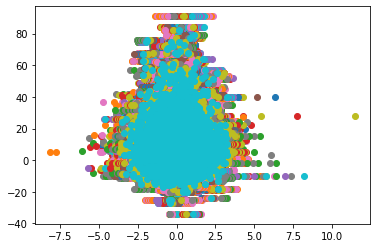

In [98]:
plt.plot(X, y, "o")

That doesn't look too good.. Let's try something more advanced

In [99]:
# how about a decision tree?
from sklearn import tree
score = []

for i in range(5, 20, 5):
    clf = tree.DecisionTreeRegressor(min_samples_leaf=5, max_depth=i, random_state=42)
    clf = clf.fit(X_train, y_train)
    clf_score = clf.score(X_test, y_test)
    score.append(clf_score)

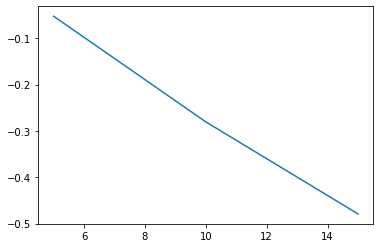

In [100]:
plt.plot(range(5, 20, 5), score)

Decision tree also does poorly, furthermore deeper trees overfit. Oh-oh..

Text(0, 0.5, 'Principal Component 2')

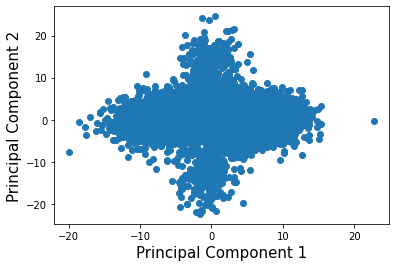

In [101]:
# Do some PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
finalDf = pd.concat([principalDf, y], axis = 1)

plt.scatter(finalDf['pc1'], finalDf['pc2'])
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)


In [102]:
i = pca.components_[0,:].argmax()
names[i]

'x_0.9_RT'

In [108]:
## Random forest

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 55)
# Train the model on training data
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

-0.052241898817315446

In [119]:
## Random forest

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 55)
# Train the model on training data
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

-0.023157016737683334

In [115]:
data = [0.01807890749876162, -0.052241898817315446, -0.023157016737683334]
col2=['Linear Regression', 'n = 100 Random Forest', 'n = 1000 Random Forest']
df = pd.DataFrame(data, col2)

In [117]:
df.columns = ['R^2']

In [118]:
df

,R^2
Linear Regression,0.018079
n = 100 Random Forest,-0.052242
n = 1000 Random Forest,-0.023157
